In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BeitImageProcessor, BeitModel
import torch
from transformers import BertTokenizer, BertModel
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import textstat
import json
from joblib import Parallel, delayed
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
import nltk.data
from nltk.tokenize import word_tokenize

pd.options.mode.chained_assignment = None

/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_name = 'petfinder-adoption-prediction'  # 'petfinder-adoption-prediction/train'

In [3]:
print(os.listdir(f'{folder_name}'))

['test_images', 'breed_labels.csv', '.DS_Store', 'test', 'train_metadata', 'color_labels.csv', 'test_sentiment', 'test_metadata', 'StateLabels.csv', 'ColorLabels.csv', 'PetFinder-BreedLabels.csv', 'train_sentiment', 'train', 'BreedLabels.csv', 'PetFinder-ColorLabels.csv', 'train_images', 'PetFinder-StateLabels.csv', 'state_labels.csv', 'train.zip']


In [4]:
train = f'{folder_name}/train/train.csv'
test = f'{folder_name}/test/test.csv'
train_sentiment = f'{folder_name}/train_sentiment'
train_images = f'{folder_name}/train_images'
test_images = f'{folder_name}/test_images'
train_metadata = f'{folder_name}/train_metadata'

In [5]:
train_data = pd.read_csv(train)

In [9]:
train_data.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [6]:
test_data = pd.read_csv(test)

In [7]:
main_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

In [8]:
def get_max_token_size(df, col_name):
    tokenizer_BERT = BertTokenizer.from_pretrained('bert-base-uncased')
    max_size = 0
    for text in df[col_name]:
        max_size = max(max_size, tokenizer_BERT(text, max_length=512, truncation=True, return_tensors="pt")['input_ids'].size()[1])
    return max_size

# create BERT embedding for a specific col, append result cols to df, return new df
def BERT_embedX(df, col_name):
    tokenizer_BERT = BertTokenizer.from_pretrained('bert-base-uncased')
    model_BERT = BertModel.from_pretrained('bert-base-uncased')

    max_token_size = get_max_token_size(df, col_name)
    print("max token size:", max_token_size)
    
    for idx, text in enumerate(df[col_name]):
        inputs_txt = tokenizer_BERT(
            text, padding='max_length', max_length=max_token_size, 
            truncation=True, return_tensors="pt"
        )
        with torch.no_grad():
            outputs = model_BERT(**inputs_txt)
            embeddings = outputs.last_hidden_state
        attention_mask = inputs_txt['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
        embeddings = (embeddings * attention_mask).mean(dim=1).numpy()[0]  # mean pooling
        if idx % 100 == 0: print(idx) 
        for i in range(768):
            column_name = f'bert_{i+1}'
            df.loc[idx, column_name] = embeddings[i]
    
    return df

def BERT_embed(df, col_name):
    tokenizer_BERT = BertTokenizer.from_pretrained('bert-base-uncased')
    model_BERT = BertModel.from_pretrained('bert-base-uncased')

    max_token_size = get_max_token_size(df, col_name)
    print("max token size:", max_token_size)
    
    # Prepare the dictionary to collect embeddings
    embedding_dict = {f'bert_{i+1}': [] for i in range(768)}
    
    for idx, text in enumerate(df[col_name]):
        # Tokenize and encode the text
        inputs_txt = tokenizer_BERT(
            text, padding='max_length', max_length=max_token_size,
            truncation=True, return_tensors="pt"
        )
        with torch.no_grad():
            # Get the embeddings from BERT
            outputs = model_BERT(**inputs_txt)
            embeddings = outputs.last_hidden_state
            # Apply attention mask
            attention_mask = inputs_txt['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
            embeddings = (embeddings * attention_mask).mean(dim=1).numpy()[0]  # mean pooling

        # Print progress every 100 entries
        if idx % 100 == 0:
            print(f'Processed {idx} rows')

        # Store the embeddings in the dictionary
        for i, embedding_value in enumerate(embeddings):
            embedding_dict[f'bert_{i+1}'].append(embedding_value)
        
    # Convert the dictionary to a DataFrame
    embedding_df = pd.DataFrame(embedding_dict)
    # Concatenate the new DataFrame with the original DataFrame
    new_df = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)
    
    return new_df

In [14]:
embed_train_data = train_data[['PetID', 'Description', 'PhotoAmt']]
embed_train_data['Description'] = embed_train_data['Description'].fillna('')
embed_test_data = test_data[['PetID', 'Description', 'PhotoAmt']]
embed_test_data['Description'] = embed_test_data['Description'].fillna('')

# other

In [27]:
main_data['RescuerID_cnt'] = main_data.groupby('RescuerID')['RescuerID'].transform('count')

In [30]:
main_data['if_name_missing'] = main_data['Name'].isna().astype(int)

In [85]:
# nltk.download('punkt')

In [92]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def nltk_sentence_length(description):
    sentences = tokenizer.tokenize(str(description))
    return len(sentences)

def nltk_word_count(description):
    words = word_tokenize(str(description))
    return len(words)

main_data['Description_len'] = main_data['Description'].apply(nltk_sentence_length)
main_data['Description_word_cnt'] = main_data['Description'].apply(nltk_word_count)

In [96]:
new_cols_ALL = main_data[['PetID', 'RescuerID_cnt', 'if_name_missing', 'Description_len', 'Description_word_cnt']]

In [98]:
new_cols_ALL.to_csv('petfinder-adoption-prediction/train/new_cols_ALL.csv', index=False)

# breed

In [46]:
breed = pd.read_csv("petfinder-adoption-prediction/breed_labels.csv")
breed

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita
...,...,...,...
302,302,2,Torbie
303,303,2,Tortoiseshell
304,304,2,Turkish Angora
305,305,2,Turkish Van


In [47]:
breed = BERT_embed(breed, "BreedName")

max token size: 13
Processed 0 rows
Processed 100 rows
Processed 200 rows
Processed 300 rows


In [48]:
breed # contains BERT embedding of BreedName

,BreedID,Type,BreedName,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,...,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767,bert_768
0,1,1,Affenpinscher,-0.065815,-0.089714,0.096927,-0.090571,-0.093762,-0.060740,0.319283,...,0.154306,-0.333814,0.022619,-0.146443,-0.068986,0.103059,-0.077378,-0.036133,-0.089950,-0.053841
1,2,1,Afghan Hound,0.091734,-0.014031,-0.187330,-0.058690,0.009446,-0.048527,0.118279,...,0.070344,-0.026527,-0.030268,-0.102012,0.019668,-0.094855,-0.021342,0.000145,0.041742,-0.025441
2,3,1,Airedale Terrier,-0.006471,-0.005594,-0.057255,-0.399208,0.091867,0.008565,0.102631,...,-0.018521,-0.019315,-0.189887,-0.183832,0.130636,-0.201073,-0.140699,-0.099592,-0.050805,-0.093281
3,4,1,Akbash,-0.110780,0.085958,-0.218248,-0.135256,0.086950,0.133239,0.087077,...,-0.054033,-0.092460,0.059143,-0.071401,0.052178,-0.193799,0.041733,-0.185286,0.017750,-0.074608
4,5,1,Akita,-0.155670,-0.105321,-0.101185,0.042123,-0.182304,-0.031650,0.041389,...,0.011725,0.025069,0.064547,0.055438,0.083719,-0.331167,0.092138,-0.206966,-0.045963,-0.027514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,302,2,Torbie,0.001071,-0.093372,0.010040,-0.027961,0.020428,0.046851,0.107053,...,0.018883,-0.016414,-0.068601,-0.096202,-0.022912,-0.091266,-0.046469,0.033940,-0.022367,-0.009268
303,303,2,Tortoiseshell,-0.033835,0.007480,-0.124093,-0.068087,0.305391,0.057584,0.043091,...,-0.052804,-0.031252,-0.067580,0.113413,-0.033539,-0.130475,0.015910,0.050964,0.069187,-0.144438
304,304,2,Turkish Angora,-0.007474,0.055367,-0.203374,-0.071091,0.058709,-0.031490,0.062731,...,0.126050,-0.091941,-0.041939,0.023238,-0.016711,-0.031548,-0.030010,-0.140979,0.023999,0.027061
305,305,2,Turkish Van,0.014894,0.010437,-0.193756,-0.066941,-0.026202,-0.001747,0.073923,...,0.157708,-0.052014,-0.071810,-0.060122,0.034041,-0.110291,0.000207,-0.053295,0.006614,-0.015714


In [65]:
breed_pca = breed[['BreedID']].copy()
breed_pca

,BreedID
0,1
1,2
2,3
3,4
4,5
...,...
302,302
303,303
304,304
305,305


In [59]:
columns_to_pca = breed.loc[:, 'bert_1':'bert_768']
# Standardize the data (optional but recommended for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(columns_to_pca)

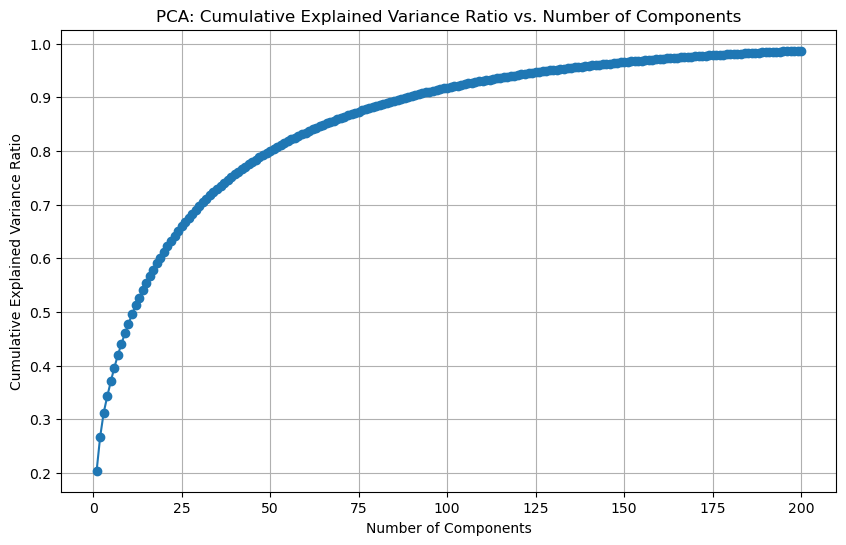

In [62]:
# Fit PCA without specifying the number of components to get all possible components
pca = PCA(n_components=200)
pca.fit(scaled_data)
# Calculate the cumulative explained variance ratios
cumulative_explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)
# Create a range from 1 to the total number of components
n_components_range = range(1, len(cumulative_explained_variance_ratios) + 1)
# Create a plot to visualize the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cumulative_explained_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [66]:
pca_df = pd.DataFrame(data=pca.fit_transform(scaled_data)[:, :], columns=[f'breed_pc_{i+1}' for i in range(200)])
breed_pca = pd.concat([breed_pca, pca_df], axis=1)
breed_pca

,BreedID,breed_pc_1,breed_pc_2,breed_pc_3,breed_pc_4,breed_pc_5,breed_pc_6,breed_pc_7,breed_pc_8,breed_pc_9,...,breed_pc_191,breed_pc_192,breed_pc_193,breed_pc_194,breed_pc_195,breed_pc_196,breed_pc_197,breed_pc_198,breed_pc_199,breed_pc_200
0,1,-10.004610,4.826958,5.967249,1.761381,-1.779957,-4.035812,-6.209944,-12.849572,2.267584,...,0.696434,-0.453725,-0.112985,0.698650,0.257448,0.068402,-0.074656,-0.236591,-0.270544,-0.013493
1,2,-11.271083,-4.349774,-1.190700,1.278809,-0.358130,0.307636,-0.400593,-1.080186,-2.495110,...,-0.286267,0.844518,-0.187768,0.075528,-0.363427,-0.058367,-0.142821,0.083782,1.006924,-0.337423
2,3,23.522472,-9.165115,14.618440,3.738408,1.014959,-1.648197,-0.800628,0.143775,0.089251,...,0.752402,0.285249,0.603733,-0.116285,-0.653764,-0.115556,-0.145156,0.128220,0.005219,0.083454
3,4,-8.841064,2.024964,2.531964,3.418181,1.050241,-2.595012,-6.103243,3.567109,0.366717,...,0.267626,0.863634,0.470421,0.112950,0.954571,0.461327,0.442463,0.429069,0.185000,-0.186203
4,5,-7.828719,0.919051,4.377195,-1.015916,4.529875,-1.457707,-6.614891,5.948831,2.580723,...,-0.213444,0.052688,0.217804,0.210017,0.345396,-0.549227,0.062862,-0.018309,0.340929,-0.173522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,302,-13.549037,-3.638999,2.700440,1.307150,-1.494835,3.045192,-0.415746,-1.535884,1.525702,...,0.120608,0.422517,-0.044710,0.206062,0.654037,-0.237883,-0.136773,-0.053288,0.011776,-0.338423
303,303,5.756157,6.680616,-8.303611,-7.888056,7.180093,0.182432,-0.740564,-3.519753,1.427071,...,-0.346738,-0.179483,0.897220,0.144672,-0.980688,-0.428592,-0.347776,-0.244758,0.382924,1.242384
304,304,-5.922915,-0.360198,-4.117766,2.245301,-0.612929,-3.865598,0.626743,2.839050,1.244158,...,0.753724,0.021669,-0.655743,0.405382,0.136524,0.025284,-0.079933,0.818874,-0.606471,-0.139214
305,305,-10.807700,-3.081841,-1.427726,1.858072,-0.084453,-2.155649,0.935537,0.658544,-0.672073,...,0.046708,-0.483805,-0.234534,0.258166,-0.453498,0.759695,0.861552,0.228514,0.571269,0.167336


In [67]:
breed_pca.to_csv('petfinder-adoption-prediction/train/breed_pca200.csv', index=False)

# image

In [275]:
feature_extractor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224')
model_BEiT = BeitModel.from_pretrained('microsoft/beit-base-patch16-224')

In [278]:
# image = Image.open(f'{train_images}/' + pet_id + f'-{1}.jpg')
# inputs_img = feature_extractor(images=image, return_tensors="pt")
# # Obtain the embeddings from the BEiT model
# with torch.no_grad():
#     outputs = model_BEiT(**inputs_img)
#     embeddings = outputs.last_hidden_state.mean(dim=1) # .mean(dim=1) to do mean pooling
# print(embeddings.shape)

torch.Size([1, 768])


In [150]:
# create BEiT embedding for a specific col, append result cols to df, return new df
def BEiT_embed(df, col_name, cnt_col, new_col_names, test=True):
    
    feature_extractor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224')
    model_BEiT = BeitModel.from_pretrained('microsoft/beit-base-patch16-224')

    for idx, pet_id in enumerate(df[col_name]):
        if idx % 100 == 0: print(idx)
        cnt = df.loc[idx, cnt_col].astype(int)

        emb = [0] * 768
        avg_cnt = 0
        for photo_id in range(1, 1 + cnt):
            if test: image = np.array(Image.open(f'{test_images}/' + pet_id + f'-{photo_id}.jpg'))
            else: image = np.array(Image.open(f'{train_images}/' + pet_id + f'-{photo_id}.jpg'))
            if len(image.shape) < 3: continue
            inputs_img = feature_extractor(images=image, return_tensors="pt")
            with torch.no_grad():
                outputs = model_BEiT(**inputs_img)
                emb += outputs.last_hidden_state.mean(dim=1).numpy()[0]
                avg_cnt += 1
        if avg_cnt > 0: emb /= avg_cnt # take mean pooling
        for i, column_name in enumerate(new_col_names):
            df.loc[idx, column_name] = emb[i]

    return df

In [323]:
# create BEiT embedding for a specific col, append result cols to df, return new df
def BEiT_embed_4cnt(df, col_name, cnt_col, test=True):
    
    pd.options.mode.chained_assignment = None
    feature_extractor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224')
    model_BEiT = BeitModel.from_pretrained('microsoft/beit-base-patch16-224')

    for idx, pet_id in enumerate(df[col_name]):
        if idx % 100 == 0: print(idx)
        cnt = df.loc[idx, cnt_col].astype(int)

        emb = [0] * 768
        total_cnt = 0
        for photo_id in range(1, 1 + cnt):
            if test: image = np.array(Image.open(f'{test_images}/' + pet_id + f'-{photo_id}.jpg'))
            else: image = np.array(Image.open(f'{train_images}/' + pet_id + f'-{photo_id}.jpg'))
            if len(image.shape) < 3: continue
            inputs_img = feature_extractor(images=image, return_tensors="pt")
            with torch.no_grad():
                outputs = model_BEiT(**inputs_img)
                emb = outputs.last_hidden_state.mean(dim=1).numpy()[0]
                total_cnt += 1
            for i in range(768):
                column_name = f'beit_{total_cnt}_{i+1}'
                df.loc[idx, column_name] = emb[i]
            if total_cnt == 4: break
        
        while total_cnt < 4:
            total_cnt += 1
            for i in range(768):
                column_name = f'beit_{total_cnt}_{i+1}'
                df.loc[idx, column_name] = 0        
    return df

In [342]:
def BEiT_embed_4cnt(df, col_name, cnt_col, test=True):
    feature_extractor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224')
    model_BEiT = BeitModel.from_pretrained('microsoft/beit-base-patch16-224')

    # Initialize a dictionary to store embeddings
    embedding_dict = {f'beit_{photo_id}_{feat_num}': [] for photo_id in range(1, 5) for feat_num in range(1, 769)}

    for idx, row in df.iterrows():
        if idx % 100 == 0: print(f'Processing index: {idx}')
        
        pet_id = row[col_name]
        cnt = min(int(row[cnt_col]), 4)  # Ensure we don't exceed 4 images

        for photo_id in range(1, cnt + 1):
            image_path = f"{test_images if test else train_images}/{pet_id}-{photo_id}.jpg"
            image = np.array(Image.open(image_path))
            if len(image.shape) < 3: continue # Skip grayscale images

            inputs = feature_extractor(images=image, return_tensors="pt")
            with torch.no_grad():
                outputs = model_BEiT(**inputs)
                emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

            for feat_num, value in enumerate(emb, start=1):
                embedding_dict[f'beit_{photo_id}_{feat_num}'].append(value)

        # Append zeros for missing images up to 4
        for missing_photo_id in range(cnt + 1, 5):
            for feat_num in range(1, 769):
                embedding_dict[f'beit_{missing_photo_id}_{feat_num}'].append(0)

    # Convert dictionary to DataFrame and concatenate with original DataFrame
    embedding_df = pd.DataFrame(embedding_dict)
    new_df = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)
    
    return new_df

In [351]:
def BEiT_embed_4cnt(df, col_name, cnt_col, test=True):
    feature_extractor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224')
    model_BEiT = BeitModel.from_pretrained('microsoft/beit-base-patch16-224')

    # Initialize a dictionary to store embeddings
    embedding_dict = {f'beit_{photo_id}_{feat_num}': [] for photo_id in range(1, 5) for feat_num in range(1, 769)}

    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f'Processing index: {idx}')
        
        pet_id = row[col_name]
        cnt = int(row[cnt_col])
        
        for photo_id in range(1, min(cnt, 4) + 1):
            try:
                image_path = f"{test_images if test else train_images}/{pet_id}-{photo_id}.jpg"
                image = np.array(Image.open(image_path))
                if len(image.shape) < 3:  # Skip grayscale images
                    raise ValueError("Image is grayscale and will be skipped.")

                inputs = feature_extractor(images=image, return_tensors="pt")
                with torch.no_grad():
                    outputs = model_BEiT(**inputs)
                    emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

            except (FileNotFoundError, OSError, ValueError) as e:
                print(f"Warning: {e} - Image path: {image_path}")
                emb = np.zeros(768)  # Use a zero embedding for missing or invalid images

            # Append the embedding
            for feat_num, value in enumerate(emb, start=1):
                embedding_dict[f'beit_{photo_id}_{feat_num}'].append(value)

        # Append zeros for the rest of the photos if less than 4
        for missing_photo_id in range(cnt + 1, 5):
            for feat_num in range(1, 769):
                embedding_dict[f'beit_{missing_photo_id}_{feat_num}'].append(0)

    # Convert dictionary to DataFrame and concatenate with original DataFrame
    embedding_df = pd.DataFrame(embedding_dict)
    new_df = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)
    
    return new_df

In [282]:
# embed_img_test = embed_test_data[['PetID', 'Description', 'PhotoAmt']]
# new_col_names = []
# for i in range(768):
#     column_name = f'beit_{i+1}'
#     new_col_names.append(column_name)
#     embed_img_test[column_name] = None
# embed_img_test

In [100]:
train_beit = pd.read_csv('petfinder-adoption-prediction/train/beit_emb.csv')
test_beit = pd.read_csv('petfinder-adoption-prediction/test/beit_emb.csv')

In [101]:
stacked_beit = pd.concat([train_beit, test_beit], axis=0, ignore_index=True)

In [102]:
petid_pca = stacked_beit[['PetID']].copy()
petid_pca

,PetID
0,86e1089a3
1,6296e909a
2,3422e4906
3,5842f1ff5
4,850a43f90
...,...
18960,ae57f8d52
18961,83432904d
18962,399013029
18963,fd80b8c80


In [103]:
stacked_beit

,PetID,Description,PhotoAmt,beit_1,beit_2,beit_3,beit_4,beit_5,beit_6,beit_7,...,beit_759,beit_760,beit_761,beit_762,beit_763,beit_764,beit_765,beit_766,beit_767,beit_768
0,86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,1.0,-0.310192,-0.764617,0.153615,0.855218,-1.348897,0.339460,-1.308903,...,1.303300,1.463770,3.033947,-1.797184,-1.982980,-1.005499,2.331824,1.211784,1.596617,-0.262875
1,6296e909a,I just found it alone yesterday near my apartm...,2.0,-1.947889,-2.051908,-3.998456,7.760249,-0.895648,1.113772,0.054845,...,2.884337,5.528191,8.004505,-2.461209,1.326637,3.473916,-0.983050,-0.242513,6.107772,0.687840
2,3422e4906,Their pregnant mother was dumped by her irresp...,7.0,-1.936284,3.632113,-2.366149,-2.234550,-0.762145,-1.891362,0.308356,...,1.440763,-3.761688,-0.253845,-0.777238,-5.088867,4.565547,0.682314,0.834575,3.270354,0.749964
3,5842f1ff5,"Good guard dog, very alert, active, obedience ...",8.0,0.928760,0.692954,2.410174,0.832870,0.850355,2.524782,-4.852310,...,5.553443,0.106803,2.801641,-2.431619,2.341961,1.634685,-5.768463,4.119203,3.580988,2.512032
4,850a43f90,This handsome yet cute boy is up for adoption....,3.0,-3.476561,1.888054,0.058391,7.779382,0.310170,-2.338997,-4.292289,...,8.965308,-0.649889,2.169342,-0.682172,1.420191,-3.253919,-2.564621,1.757889,4.193055,1.187112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18960,ae57f8d52,Found on the streets. Treated for mange. They ...,5.0,-0.566888,0.572006,3.168262,1.594399,1.478107,5.957041,-3.188422,...,1.849476,2.925089,3.979542,-2.982016,2.862490,2.381463,-3.367081,6.904143,4.366606,2.263007
18961,83432904d,Very good guard dog. Healthy was found in Fron...,2.0,-3.950828,-1.083821,-0.900463,-11.948193,5.082845,0.978958,-0.893967,...,-0.233856,-2.818002,-0.783887,0.712955,-2.401603,4.929399,-1.176990,1.952214,-2.424428,-0.428581
18962,399013029,these cat's mother was killed when they was ne...,1.0,-1.658330,-0.615570,1.431059,3.939951,-2.323499,-3.023821,2.488741,...,-0.056667,0.593009,0.350539,1.592952,-0.005729,0.222958,3.267806,-0.032146,2.768544,-1.257070
18963,fd80b8c80,"smokey is good family pet. very obedient,so lo...",3.0,0.184708,1.531356,-1.025481,1.185653,2.688088,1.071212,-1.191239,...,2.973277,3.352471,3.212975,-1.000046,0.826955,-1.096176,-0.229420,4.559941,3.820041,1.969298


In [104]:
columns_to_pca = stacked_beit.loc[:, 'beit_1':'beit_768']
# Standardize the data (optional but recommended for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(columns_to_pca)

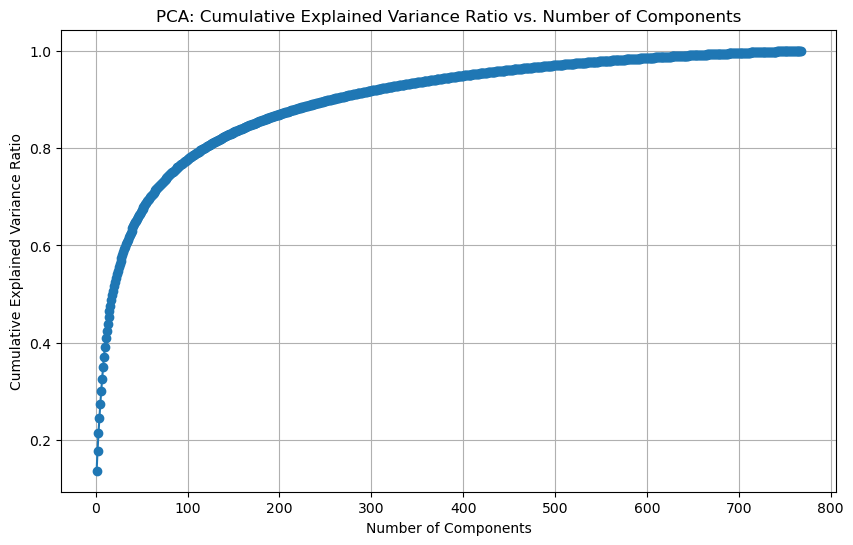

In [105]:
# Fit PCA without specifying the number of components to get all possible components
pca = PCA(n_components=768)
pca.fit(scaled_data)
# Calculate the cumulative explained variance ratios
cumulative_explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)
# Create a range from 1 to the total number of components
n_components_range = range(1, len(cumulative_explained_variance_ratios) + 1)
# Create a plot to visualize the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cumulative_explained_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [106]:
pca_df = pd.DataFrame(data=pca.fit_transform(scaled_data)[:, :], columns=[f'beit_pc_{i+1}' for i in range(768)])
petid_pca = pd.concat([petid_pca, pca_df], axis=1)
petid_pca

,PetID,beit_pc_1,beit_pc_2,beit_pc_3,beit_pc_4,beit_pc_5,beit_pc_6,beit_pc_7,beit_pc_8,beit_pc_9,...,beit_pc_759,beit_pc_760,beit_pc_761,beit_pc_762,beit_pc_763,beit_pc_764,beit_pc_765,beit_pc_766,beit_pc_767,beit_pc_768
0,86e1089a3,6.803909,-1.264357,2.336252,-1.234875,-4.548422,-3.631723,-0.451205,4.270730,5.215320,...,-0.047477,0.112660,0.108228,0.065096,0.195157,0.215720,0.185769,-0.155869,0.129212,-0.285676
1,6296e909a,6.043245,3.456949,7.058715,-0.354797,-4.862559,0.480350,0.233650,2.697986,-3.541621,...,-0.280381,0.178958,0.030842,-0.474422,-0.141075,-0.187220,0.198783,-0.028269,0.129726,-0.134564
2,3422e4906,-10.336509,16.390515,-6.932696,17.037435,-1.809301,1.542790,2.325664,-10.076636,-2.213037,...,-0.058928,-0.173317,0.068680,0.096153,0.099233,-0.299042,-0.320987,-0.111748,0.190466,-0.047779
3,5842f1ff5,-12.660611,-4.428639,4.512597,5.205920,-2.450912,-8.618918,-3.487784,-1.135478,3.790181,...,-0.038242,-0.137535,-0.304525,0.109016,-0.074774,-0.103120,0.077355,-0.069915,-0.140997,-0.023236
4,850a43f90,-7.003554,8.614632,6.543937,3.968017,4.612457,-9.097443,0.973442,6.879136,8.760399,...,0.340549,-0.178510,0.279208,0.030305,-0.021567,0.024999,0.045273,0.016797,0.338429,-0.035599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18960,ae57f8d52,-11.097511,-13.902682,2.698804,0.676699,-6.242710,-8.556242,-4.960877,-1.889421,2.123433,...,0.264854,-0.058976,0.194088,-0.087230,0.217032,0.119473,-0.226507,0.053135,0.155068,-0.082515
18961,83432904d,-9.243214,10.796463,-8.006401,1.033590,-5.331324,2.964798,3.540414,-1.562786,-6.419357,...,-0.347412,0.261711,0.012254,-0.042047,-0.122388,-0.431180,-0.029439,0.264920,0.174747,0.188100
18962,399013029,9.035892,-2.470246,0.289381,-1.524040,0.065680,-0.805357,1.366808,1.016168,-3.703771,...,-0.406343,-0.405824,-0.184152,0.027242,0.231123,-0.258381,0.181991,-0.018973,0.382691,0.315379
18963,fd80b8c80,-7.645195,-2.131113,-4.706953,0.275608,-3.457949,-1.691855,-1.027820,6.955910,-6.312354,...,0.090076,-0.145882,-0.023760,-0.190267,0.236588,-0.266630,-0.140672,-0.145762,0.147064,0.089623


In [107]:
petid_pca.to_csv('petfinder-adoption-prediction/train/beit_pca768_ALL.csv', index=False)

In [364]:
# embed_train_img = embed_train_data[['PetID', 'Description', 'PhotoAmt']]
# embed_train_img = BEiT_embed_4cnt(embed_train_img, 'PetID', 'PhotoAmt', test=False)

In [363]:
# embed_test_img = embed_test_data[['PetID', 'Description', 'PhotoAmt']]
# embed_test_img = BEiT_embed_4cnt(embed_test_img, 'PetID', 'PhotoAmt', test=True)

In [365]:
# embed_train_img.to_csv('petfinder-adoption-prediction/train/beit4_emb.csv', index=False)

In [366]:
# embed_test_img.to_csv('petfinder-adoption-prediction/test/beit4_emb.csv', index=False)

In [358]:
# stacked_beit = pd.concat([embed_train_img, embed_test_img], axis=0, ignore_index=True)

In [50]:
# stacked_beit = pd.read_csv('petfinder-adoption-prediction/train/beit4_emb.csv')

In [52]:
petid_pca = stacked_beit[['PetID']].copy()
petid_pca

,PetID
0,86e1089a3
1,6296e909a
2,3422e4906
3,5842f1ff5
4,850a43f90
...,...
14988,dc0935a84
14989,a01ab5b30
14990,d981b6395
14991,e4da1c9e4


In [53]:
columns_to_pca = stacked_beit.loc[:, 'beit_1_1':'beit_4_768']
# Standardize the data (optional but recommended for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(columns_to_pca)

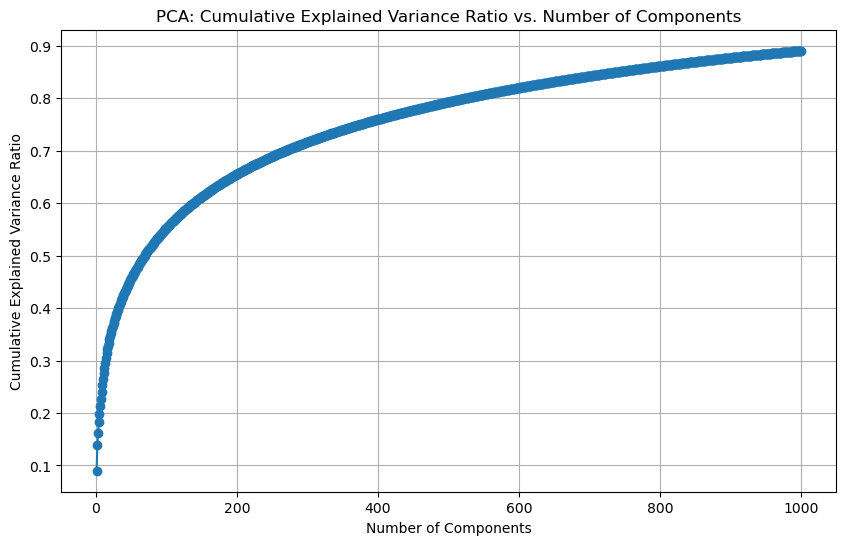

In [54]:
# Fit PCA without specifying the number of components to get all possible components
pca = PCA(n_components=1000)
pca.fit(scaled_data)
# Calculate the cumulative explained variance ratios
cumulative_explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)
# Create a range from 1 to the total number of components
n_components_range = range(1, len(cumulative_explained_variance_ratios) + 1)
# Create a plot to visualize the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cumulative_explained_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [55]:
pca_df = pd.DataFrame(data=pca.fit_transform(scaled_data)[:, :], columns=[f'beit_pc_{i+1}' for i in range(1000)])
petid_pca = pd.concat([petid_pca, pca_df], axis=1)
petid_pca

,PetID,beit_pc_1,beit_pc_2,beit_pc_3,beit_pc_4,beit_pc_5,beit_pc_6,beit_pc_7,beit_pc_8,beit_pc_9,...,beit_pc_991,beit_pc_992,beit_pc_993,beit_pc_994,beit_pc_995,beit_pc_996,beit_pc_997,beit_pc_998,beit_pc_999,beit_pc_1000
0,86e1089a3,-0.962960,-15.776959,0.193808,1.564743,2.267483,-0.866954,1.831486,1.869245,0.361090,...,0.285237,0.006121,0.183021,0.322249,-0.446294,0.047924,-0.550648,0.219834,-0.311299,-0.521835
1,6296e909a,3.260973,-11.454541,-3.588045,7.084389,3.276540,2.709465,0.935625,-0.907298,0.375712,...,0.129536,0.207389,0.034753,0.379326,0.085261,-0.104688,-0.529708,-0.715691,0.140822,-0.402046
2,3422e4906,-21.852856,28.562742,-38.086724,-22.274841,15.452772,1.510234,-26.344038,-5.750512,-14.486637,...,-0.428220,0.444007,-0.995497,1.223971,-0.962623,1.192603,-0.044912,1.132042,0.420466,-0.324308
3,5842f1ff5,-23.099631,23.082759,4.776997,10.996377,20.458276,-13.983373,8.628838,-1.072371,-7.124577,...,-0.346993,0.342848,-1.044563,-0.459829,-0.607273,-0.194173,-0.767602,0.693384,-0.413494,-0.393167
4,850a43f90,-10.511508,5.005822,-13.743798,8.472404,2.229774,-11.051504,13.147757,12.623933,-9.130885,...,-0.520753,0.497845,-0.623437,0.370604,-0.649197,0.110252,-1.382230,0.325617,-0.371961,0.303012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,dc0935a84,7.618604,-1.739594,-4.590335,5.432770,5.744232,2.119807,8.174962,9.435816,-4.044490,...,0.757870,0.559750,0.083342,0.019061,-0.073866,0.198175,0.727047,0.643137,-1.197692,0.017294
14989,a01ab5b30,14.752681,-3.248388,-1.070036,-3.064912,-1.488846,0.626013,-3.107940,4.372044,-4.972501,...,0.482932,0.114368,-0.240704,-1.074419,0.002056,-0.265309,-0.344731,0.050111,0.085789,0.203626
14990,d981b6395,22.439319,14.862036,-8.033082,-2.228932,3.250362,-2.111401,3.078900,-5.274895,11.609056,...,0.149939,-0.073784,0.477055,-0.146342,-0.278822,-0.660242,-0.170007,0.777832,0.678366,-1.019129
14991,e4da1c9e4,9.115844,-4.939210,4.798468,0.443590,-0.576778,2.377388,0.777011,0.595310,-0.403685,...,0.088144,0.458438,0.608887,0.182717,0.466213,0.377123,0.231273,0.438599,0.266888,-0.487927


In [56]:
petid_pca.to_csv('petfinder-adoption-prediction/train/beit4_pca1000.csv', index=False)

# text

In [10]:
tokenizer_BERT = BertTokenizer.from_pretrained('bert-base-uncased')
model_BERT = BertModel.from_pretrained('bert-base-uncased')

In [22]:
# description = embed_main_data.loc[0, 'Description']
# inputs_txt = tokenizer_BERT(description, return_tensors="pt")
# # Obtain the embeddings from the BERT model
# with torch.no_grad():
#     outputs = model_BERT(**inputs_txt)
#     embeddings = outputs.last_hidden_state #.mean(dim=1) # .mean(dim=1) to do mean pooling
# print(embeddings.shape)
# attention_mask_expanded = inputs_txt['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
# masked_embeddings = embeddings * attention_mask_expanded

torch.Size([1, 85, 768])


In [40]:
max_token_size = get_max_token_size(embed_main_data, 'Description')

In [155]:
max_token_size_test = get_max_token_size(embed_test_data, 'Description')

In [362]:
# embed_main_data = BERT_embed(embed_main_data, 'Description', max_token_size)

In [361]:
# embed_test_data_bert = BERT_embed(embed_test_data, 'Description', max_token_size_test)

In [50]:
embed_main_data.to_csv('petfinder-adoption-prediction/train/bert_emb.csv', index=False)

In [159]:
embed_test_data_bert.to_csv('petfinder-adoption-prediction/test/bert_emb.csv', index=False)

In [14]:
def BERT_embed512(df, col_name, max_token_size=512):
    tokenizer_BERT = BertTokenizer.from_pretrained('bert-base-uncased')
    model_BERT = BertModel.from_pretrained('bert-base-uncased')

    # Prepare the dictionary to collect embeddings
    embedding_dict = {f'bert_{i+1}': [] for i in range(max_token_size*768)}
    
    for idx, text in enumerate(df[col_name]):
        # Tokenize and encode the text
        inputs_txt = tokenizer_BERT(
            text, padding='max_length', max_length=max_token_size,
            truncation=True, return_tensors="pt"
        )
        with torch.no_grad():
            # Get the embeddings from BERT
            outputs = model_BERT(**inputs_txt)
            embeddings = outputs.last_hidden_state
            # Apply attention mask
            attention_mask = inputs_txt['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
            masked_embeddings = embeddings * attention_mask
            # Flatten the embeddings tensor to a 1D array
            flat_embeddings = masked_embeddings.view(-1).numpy()

        # Print progress every 100 entries
        if idx % 100 == 0:
            print(f'Processed {idx} rows')

        # Store the embeddings in the dictionary
        for i, embedding_value in enumerate(flat_embeddings):
            embedding_dict[f'bert_{i+1}'].append(embedding_value)
        
    # Convert the dictionary to a DataFrame
    embedding_df = pd.DataFrame(embedding_dict)
    # Concatenate the new DataFrame with the original DataFrame
    new_df = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)
    
    return new_df

In [68]:
# embed_train_bert = embed_train_data[['PetID', 'Description']]
# embed_train_bert = BERT_embed512(embed_train_bert, 'Description')

In [69]:
# embed_test_bert = embed_test_data[['PetID', 'Description']]
# embed_test_bert = BERT_embed512(embed_test_bert, 'Description')

In [70]:
embed_train_bert = pd.read_csv('petfinder-adoption-prediction/train/bert_emb.csv')
embed_test_bert = pd.read_csv('petfinder-adoption-prediction/test/bert_emb.csv')

stacked_bert = pd.concat([embed_train_bert, embed_test_bert], axis=0, ignore_index=True)
stacked_bert

,PetID,Description,PhotoAmt,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,...,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767,bert_768
0,86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,1.0,-0.043683,-0.003359,0.057938,-0.009149,0.074987,0.002144,-0.001361,...,-0.054421,-0.005467,-0.007617,-0.019234,-0.008028,-0.042475,-0.026322,-0.064947,0.021249,0.016880
1,6296e909a,I just found it alone yesterday near my apartm...,2.0,0.002667,-0.006170,0.003226,0.017490,0.018490,0.002011,0.011094,...,-0.007648,0.001526,0.011457,-0.016518,-0.000072,-0.010434,-0.003308,-0.009326,-0.019766,0.007423
2,3422e4906,Their pregnant mother was dumped by her irresp...,7.0,0.032429,-0.015281,0.049209,-0.027811,0.057014,0.001007,0.014452,...,-0.068438,0.000876,-0.013065,-0.024226,-0.040832,-0.033867,-0.063789,-0.054335,-0.000282,-0.019037
3,5842f1ff5,"Good guard dog, very alert, active, obedience ...",8.0,0.010549,-0.010476,0.048989,-0.011282,0.009198,-0.007510,0.020444,...,-0.007285,-0.013800,0.012178,-0.021044,-0.015850,-0.015979,-0.016011,-0.025901,0.001068,-0.011094
4,850a43f90,This handsome yet cute boy is up for adoption....,3.0,-0.011000,0.001728,0.082671,0.010937,0.112642,-0.011762,-0.008066,...,-0.057833,0.019821,0.048089,-0.020422,-0.010442,-0.092624,-0.015575,-0.045186,0.078788,0.009945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18960,ae57f8d52,Found on the streets. Treated for mange. They ...,5.0,-0.002222,-0.007372,0.021954,-0.003778,0.020238,-0.008215,0.025700,...,-0.008606,0.009914,-0.003754,-0.000381,0.000925,-0.018749,-0.001003,-0.021435,0.016050,-0.013037
18961,83432904d,Very good guard dog. Healthy was found in Fron...,2.0,-0.007146,-0.010944,0.006802,-0.013146,0.021622,0.000141,0.015258,...,-0.004299,0.021277,-0.005618,-0.009904,-0.004501,-0.018652,-0.001468,-0.026882,0.003617,-0.003290
18962,399013029,these cat's mother was killed when they was ne...,1.0,0.018221,0.002583,0.051930,-0.001997,0.026297,-0.005811,0.017130,...,-0.010146,0.005115,-0.000416,-0.017947,-0.015372,-0.031573,-0.011631,-0.046246,0.016198,0.011877
18963,fd80b8c80,"smokey is good family pet. very obedient,so lo...",3.0,-0.016813,0.009180,0.028813,0.001147,0.021321,-0.022011,0.024838,...,-0.025349,0.003712,-0.008274,-0.013971,-0.002092,-0.021390,-0.000487,-0.022202,0.017251,-0.010484


In [73]:
petid_pac = stacked_bert[['PetID']].copy()
petid_pac

,PetID
0,86e1089a3
1,6296e909a
2,3422e4906
3,5842f1ff5
4,850a43f90
...,...
18960,ae57f8d52
18961,83432904d
18962,399013029
18963,fd80b8c80


In [74]:
columns_to_pca = stacked_bert.loc[:, 'bert_1':'bert_768']
# Standardize the data (optional but recommended for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(columns_to_pca)

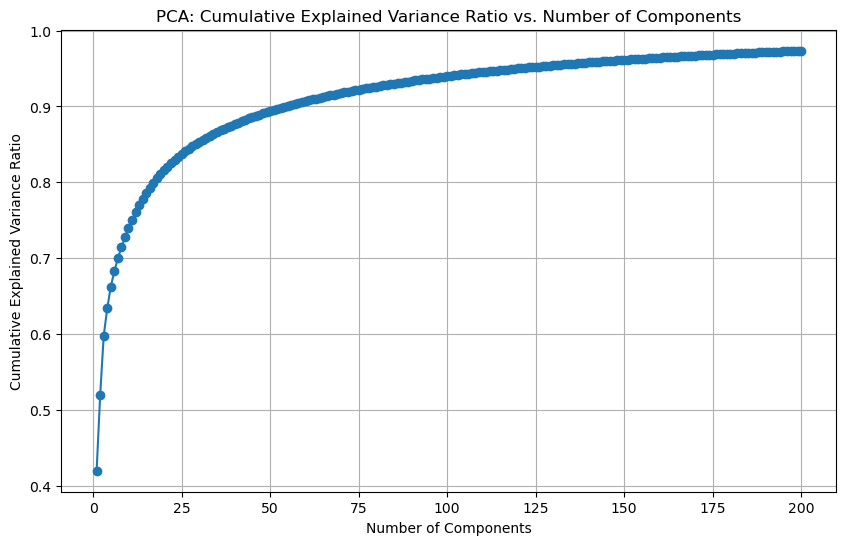

In [76]:
# Fit PCA without specifying the number of components to get all possible components
pca = PCA(n_components=200)
pca.fit(scaled_data)
# Calculate the cumulative explained variance ratios
cumulative_explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)
# Create a range from 1 to the total number of components
n_components_range = range(1, len(cumulative_explained_variance_ratios) + 1)
# Create a plot to visualize the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cumulative_explained_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [77]:
pca_df = pd.DataFrame(data=pca.fit_transform(scaled_data)[:, :], columns=[f'bert_pc_{i+1}' for i in range(200)])
petid_pac = pd.concat([petid_pac, pca_df], axis=1)
petid_pac

,PetID,bert_pc_1,bert_pc_2,bert_pc_3,bert_pc_4,bert_pc_5,bert_pc_6,bert_pc_7,bert_pc_8,bert_pc_9,...,bert_pc_191,bert_pc_192,bert_pc_193,bert_pc_194,bert_pc_195,bert_pc_196,bert_pc_197,bert_pc_198,bert_pc_199,bert_pc_200
0,86e1089a3,-0.355262,-2.428477,2.764858,-2.691599,-2.440353,-0.843628,0.155011,-0.055925,1.478828,...,0.104903,0.179072,0.204197,-0.035357,-0.475749,0.424977,-0.049955,-0.010710,-0.161888,0.186728
1,6296e909a,-13.090230,0.448666,0.320625,-1.369651,-0.199614,1.007208,-3.413226,-1.773917,2.276836,...,-0.180913,-0.095447,-0.737532,-0.152580,-0.031470,0.353877,-0.029334,-0.312755,0.165715,-0.011905
2,3422e4906,3.708703,-0.626718,-1.111137,-1.786498,-0.736559,-4.032025,-0.879210,-0.441144,1.594330,...,-0.065538,0.027997,0.160716,0.074454,-0.085173,0.018602,0.104535,-0.043613,0.033612,0.169148
3,5842f1ff5,-9.846854,0.437564,0.139617,0.479870,2.714569,-0.206900,-0.006070,-1.139237,-0.905581,...,0.156932,0.171609,0.510358,0.191496,-0.049023,-0.136637,0.093590,0.314634,-0.273915,-0.138144
4,850a43f90,3.693212,-5.684371,5.555192,-9.335610,-2.974644,-0.937191,-1.764388,3.945661,-1.494478,...,0.176946,0.291880,-0.481562,-0.167419,-0.256427,0.255880,0.404912,0.312547,0.109933,-0.257740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18960,ae57f8d52,-11.660158,0.123014,0.263315,2.418366,-0.439806,1.157474,2.410195,0.121217,0.592945,...,-0.101537,-0.079522,0.160457,0.131488,0.004924,0.034874,0.022980,-0.072183,0.104255,0.010127
18961,83432904d,-11.312989,0.177102,0.156064,1.715282,0.524905,0.053983,0.920307,-0.441386,2.215046,...,0.086368,0.048921,0.030744,0.441478,-0.074306,0.150420,-0.328107,0.104370,-0.036324,-0.087190
18962,399013029,-8.374558,-0.689730,0.398934,2.157945,0.187454,0.218257,-2.543068,-0.631992,0.246258,...,-0.043563,-0.231532,0.241482,0.301567,-0.348961,-0.054452,-0.160345,0.114024,-0.113877,-0.434409
18963,fd80b8c80,-10.294728,0.515538,-0.027276,1.283227,-0.282185,1.369175,2.150779,0.108089,-0.088108,...,0.249261,-0.356544,0.120724,0.044878,-0.058110,0.017643,0.010443,-0.065471,-0.074049,-0.356912


In [78]:
petid_pac.to_csv('petfinder-adoption-prediction/train/bert_pca200_ALL.csv', index=False)

# sentiment & readability

In [194]:
embed_train_data = main_data[['PetID', 'Description', 'PhotoAmt']]
embed_train_data['Description'] = embed_train_data['Description'].fillna('')

In [189]:
embed_test_data = test_data[['PetID', 'Description', 'PhotoAmt']]
embed_test_data['Description'] = embed_test_data['Description'].fillna('')

In [186]:
# create BERT embedding for a specific col, append result cols to df, return new df
def text_embed(df, col_name, max_token_size):
    
    for i in range(5):
        df[f'sentiment_{i+1}'] = None
    df['FleschRead'] = None
    df['GunningRead'] = None
    df['AutomatedRead'] = None
    
    # Load model and tokenizer
    model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    for idx, text in enumerate(df[col_name]):
        # Encode text
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Get prediction (logits)
        with torch.no_grad():
            logits = model(**inputs).logits

        # Convert logits to probabilities with softmax
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        if idx % 2000 == 0: print(idx)
        for i in range(5):
            column_name = f'sentiment_{i+1}'
            df.loc[idx, column_name] = probabilities[0, i].item()
        
        # Calculate Flesch Reading Ease
        flesch_reading_ease = textstat.flesch_reading_ease(text)
        df.loc[idx, 'FleschRead'] = flesch_reading_ease

        # Calculate Gunning Fog Index
        gunning_fog = textstat.gunning_fog(text)
        df.loc[idx, 'GunningRead'] = gunning_fog

        # Calculate Automated Readability Index
        automated_readability_index = textstat.automated_readability_index(text)
        df.loc[idx, 'AutomatedRead'] = automated_readability_index

    return df

In [187]:
embed_train_data = text_embed(embed_train_data, 'Description', max_token_size)
embed_train_data

0
2000
4000
6000
8000
10000
12000
14000


,PetID,Description,PhotoAmt,sentiment_1,sentiment_2,sentiment_3,sentiment_4,sentiment_5,FleschRead,GunningRead,AutomatedRead
0,86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,1.0,0.024144,0.067198,0.201417,0.441064,0.266176,85.18,5.76,4.2
1,6296e909a,I just found it alone yesterday near my apartm...,2.0,0.195428,0.397096,0.305467,0.077449,0.024559,85.18,6.34,4.0
2,3422e4906,Their pregnant mother was dumped by her irresp...,7.0,0.017111,0.047825,0.176763,0.475677,0.282623,78.35,6.86,5.7
3,5842f1ff5,"Good guard dog, very alert, active, obedience ...",8.0,0.004016,0.007084,0.064101,0.518351,0.406449,63.02,11.6,14.1
4,850a43f90,This handsome yet cute boy is up for adoption....,3.0,0.001929,0.003098,0.016425,0.258557,0.719991,100.38,5.79,3.6
...,...,...,...,...,...,...,...,...,...,...,...
14988,dc0935a84,I have 4 kittens that need to be adopt urgentl...,3.0,0.006147,0.022971,0.118696,0.482486,0.3697,83.66,6.74,4.3
14989,a01ab5b30,Serato(female cat- 3 color) is 4 years old and...,3.0,0.058714,0.213486,0.345171,0.267772,0.114856,77.94,6.7,5.3
14990,d981b6395,"Mix breed, good temperament kittens. Love huma...",5.0,0.003034,0.004836,0.053311,0.404708,0.534111,53.88,8.04,12.4
14991,e4da1c9e4,she is very shy..adventures and independent..s...,3.0,0.008783,0.04771,0.316562,0.522047,0.104898,67.82,5.88,10.7


In [191]:
embed_test_data = text_embed(embed_test_data, 'Description', max_token_size)
embed_test_data

0
2000


,PetID,Description,PhotoAmt,sentiment_1,sentiment_2,sentiment_3,sentiment_4,sentiment_5,FleschRead,GunningRead,AutomatedRead
0,e2dfc2935,"Dopey Age: 8mths old Male One half of a pair, ...",2.0,0.005528,0.017864,0.145406,0.602896,0.228307,91.41,6.31,5.6
1,f153b465f,"Please note that Chichi has been neutered, the...",1.0,0.257829,0.422151,0.249143,0.060634,0.010242,77.33,6.47,7.9
2,3c90f3f54,"Sticky, named such because of his tendency to ...",4.0,0.022781,0.042031,0.125241,0.485232,0.324715,81.12,7.49,7.4
3,e02abc8a3,Dannie and Kass are mother and daughter. We en...,5.0,0.03959,0.145843,0.283343,0.377588,0.153636,82.44,7.18,5.5
4,09f0df7d1,"Extremely cuddly cat, hence the origin of his ...",5.0,0.054225,0.110577,0.185961,0.374764,0.274474,84.37,5.74,4.3
...,...,...,...,...,...,...,...,...,...,...,...
3967,ae57f8d52,Found on the streets. Treated for mange. They ...,5.0,0.001635,0.002434,0.036383,0.408686,0.550862,83.02,4.02,5.2
3968,83432904d,Very good guard dog. Healthy was found in Fron...,2.0,0.001023,0.002948,0.054425,0.724953,0.216651,114.12,3.2,-0.7
3969,399013029,these cat's mother was killed when they was ne...,1.0,0.173267,0.143684,0.178394,0.207382,0.297272,71.82,14.41,15.7
3970,fd80b8c80,"smokey is good family pet. very obedient,so lo...",3.0,0.001779,0.002933,0.037769,0.435568,0.521951,70.29,8.01,9.4


In [192]:
embed_train_data.to_csv('petfinder-adoption-prediction/train/txt_emb.csv', index=False)
embed_test_data.to_csv('petfinder-adoption-prediction/test/txt_emb.csv', index=False)

In [272]:
embed_train_data['PhotoAmt'].mean()
embed_test_data['PhotoAmt'].mean()

3.641742195367573

# metadata?

In [255]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        self.debug = debug
        self.sentence_sep = ' '
        # Does not have to be extracted because main DF already contains description
        self.extract_sentiment_text = False

    def open_sentiment_file(self, filename):
        """ Load sentiment file. """
        with open(filename, 'r') as f:
            sentiment_file = json.load(f)
        return sentiment_file
            
    def open_image_file(self, filename):
        """ Load image file. """
        image = np.asarray(Image.open(filename))
        return image

    def open_metadata_file(self, filename):
        """ Load metadata file. """
        with open(filename, 'r') as f:
            metadata_file = json.load(f)
        return metadata_file

    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """

        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)

        if self.extract_sentiment_text:
            file_sentences_text = [x['text']['content'] for x in file['sentences']]
            file_sentences_text = self.sentence_sep.join(file_sentences_text)
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]

        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns').sum()
        file_sentences_sentiment = file_sentences_sentiment.add_prefix('document_').to_dict()

        file_sentiment.update(file_sentences_sentiment)

        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        if self.extract_sentiment_text:
            df_sentiment['text'] = file_sentences_text
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')

        return df_sentiment

    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """

        file_keys = list(file.keys())

        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.3)]
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']

        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()

        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }

        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')

        return df_metadata

# Helper function for parallel data processing:
def extract_additional_features(pet_id, mode='train'):

    sentiment_filename = 'petfinder-adoption-prediction/{}_sentiment/{}.json'.format(mode, pet_id)
    try:
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob('petfinder-adoption-prediction/{}_metadata/{}*.json'.format(mode, pet_id)))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_metadata_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]

    return dfs

pet_parser = PetFinderParser()

In [256]:
train = pd.read_csv('petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('petfinder-adoption-prediction/test/test.csv')

In [257]:
# Unique IDs from train and test:
debug = False
train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

if debug:
    train_pet_ids = train_pet_ids[:1000]
    test_pet_ids = test_pet_ids[:500]

# Train set:
# Parallel processing of data:
dfs_train = Parallel(n_jobs=1, verbose=1)( 
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)
# Extract processed data and format them as DFs:
train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]
train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)
print(train_dfs_sentiment.shape, train_dfs_metadata.shape)

# Test set:
# Parallel processing of data:
dfs_test = Parallel(n_jobs=1, verbose=1)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)
# Extract processed data and format them as DFs:
test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]
test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)
print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   15.5s
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:  5.1min
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] f

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed: 13.1min
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] f

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed: 17.1min
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] 

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

(14442, 6) (58311, 7)


/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] fo

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:   31.1s
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] f

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/3w/066ghmln7rzch80_lzxq_p700000gn/T/ipykernel_91342/582280456.py:63: RuntimeWarning: Mean of empty slice.
  file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
/Users/shendongming/miniconda3/en

(3865, 6) (14465, 7)


In [258]:
# Extend aggregates and improve column naming
aggregates = ['mean', 'sum']


# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(aggregates)
train_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(aggregates)
test_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

In [266]:
train_metadata_gr.to_csv('petfinder-adoption-prediction/train/metadata_gr.csv', index=False)
train_sentiment_gr.to_csv('petfinder-adoption-prediction/train/sentiment_gr.csv', index=False)
test_metadata_gr.to_csv('petfinder-adoption-prediction/test/metadata_gr.csv', index=False)
test_sentiment_gr.to_csv('petfinder-adoption-prediction/test/sentiment_gr.csv', index=False)